In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
train_cat=train_df['Embarked'] ; test_cat=test_df['Embarked']
train_df.drop(columns=['Name','Ticket'],inplace=True) ; test_df.drop(columns=['Name','Ticket'],inplace=True) 
train_df['Cabin']=train_df['Cabin'].fillna(value=0)   ; test_df['Cabin']=test_df['Cabin'].fillna(value=0)
train_df['Cabin']=train_df['Cabin'].mask(train_df['Cabin'] != 0 , other=1)
test_df['Cabin']=test_df['Cabin'].mask(test_df['Cabin'] != 0 , other=1)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Embarked= encoder.fit_transform(train_cat)
Embarked_1=encoder.fit_transform(test_cat)
train_df['Embarked']=Embarked  ; test_df['Embarked']=Embarked_1
Target=pd.DataFrame(train_df['Survived']) 
train_df.drop(columns='Survived',inplace=True)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_scaled=scaler.fit_transform(train_df.astype(np.float64))
test_scaled=scaler.fit_transform(test_df.astype(np.float64))

In [21]:
where_are_NaNs = np.isnan(test_scaled)
test_scaled[where_are_NaNs] = 0

In [3]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(train_scaled, Target)
#train_df.columns
#from sklearn.tree import export_graphviz
#export_graphviz(tree_clf,out_file="titanic_tree.dot",feature_names=train_df.columns,
 #               class_names='Survived',rounded=True,filled=True)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [4]:
from sklearn.model_selection import cross_val_score
cross_val_score(tree_clf, train_scaled, Target, cv=3, scoring="accuracy")
from sklearn.model_selection import cross_val_predict
train_pred = cross_val_predict(tree_clf, train_scaled, Target, cv=3)

In [5]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Target,train_pred)

array([[489,  60],
       [136, 206]], dtype=int64)

In [6]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(Target, train_pred)) 
print(recall_score(Target, train_pred))

0.7744360902255639
0.6023391812865497


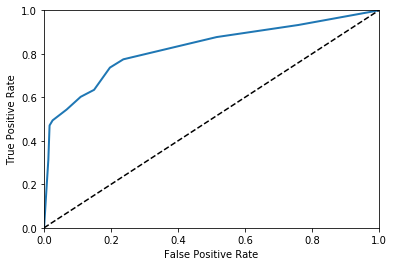

In [7]:
from sklearn.metrics import roc_curve
train_scores= cross_val_predict(tree_clf, train_df, Target, cv=3,method='predict_proba')
train_scores=train_scores[:,1]
fpr,tpr,thresholds = roc_curve(Target, train_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [8]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Target, train_scores)

0.8245693925158981

In [9]:
from sklearn.linear_model import LogisticRegression
Log_reg= LogisticRegression()
Log_reg.fit(train_scaled,Target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [10]:
train_pred_1 = cross_val_predict(Log_reg, train_scaled, Target, cv=3)
train_scores_1=cross_val_predict(Log_reg,train_scaled,Target,cv=3,method='decision_function')
print(confusion_matrix(Target,train_pred_1))
roc_auc_score(Target, train_scores_1)

[[464  85]
 [101 241]]


0.8492314575144602

In [11]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(train_scaled, Target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
train_pred_2=cross_val_predict(rnd_clf,train_scaled,Target,cv=3)
train_scores_2=cross_val_predict(rnd_clf,train_scaled,Target,cv=3,method='predict_proba')
train_scores_2 = train_scores_2[:, 1]
print(confusion_matrix(Target,train_pred_2))
roc_auc_score(Target, train_scores_2)


[[491  58]
 [112 230]]


0.8616756676146955

### Ensembling

In [39]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('lr', Log_reg), ('rf', rnd_clf), ('dt', tree_clf)],voting='soft')
voting_clf.fit(train_scaled, Target)

from sklearn.metrics import accuracy_score
for clf in (Log_reg, rnd_clf, tree_clf, voting_clf):
    clf.fit(train_scaled, Target)
    y_pred = clf.predict(train_scaled)
    print(clf.__class__.__name__, accuracy_score(Target, y_pred))

('LogisticRegression', 0.7991021324354658)
('RandomForestClassifier', 0.8900112233445566)
('DecisionTreeClassifier', 0.7867564534231201)
('VotingClassifier', 0.8473625140291807)


In [40]:
train_pred_VC=cross_val_predict(voting_clf,train_scaled,Target,cv=3)
train_scores_VC=cross_val_predict(voting_clf,train_scaled,Target,cv=3,method='predict_proba')
train_scores_VC = train_scores_VC[:, 1]
print(confusion_matrix(Target,train_pred_VC))
roc_auc_score(Target, train_scores_VC)

[[487  62]
 [108 234]]


0.8587650060183853

### Grid Search CV

In [53]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [500, 1000, 1500], 'bootstrap': [True], 'max_leaf_nodes' : [8,16], 'n_jobs':[-1]},
{'bootstrap': [False], 'n_estimators': [500, 1000], 'max_leaf_nodes': [8, 16, 24]},
]
grid_search = GridSearchCV(rnd_clf, param_grid, cv=3,scoring='roc_auc')
grid_search.fit(train_scaled,Target)
print(grid_search.best_params_)

C:\Users\ACER M5\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ACER M5\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ACER M5\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ACER M5\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector 

C:\Users\ACER M5\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ACER M5\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ACER M5\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ACER M5\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector 

{'n_estimators': 500, 'max_leaf_nodes': 24, 'bootstrap': False}


### parameters of gridsearch CV

In [41]:
rnd_clf_gd = RandomForestClassifier(n_estimators=500, bootstrap=False,max_leaf_nodes=24, n_jobs=-1)
rnd_clf_gd.fit(train_scaled, Target)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=24,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
train_pred_gd=cross_val_predict(rnd_clf_gd,train_scaled,Target,cv=3)
train_scores_gd=cross_val_predict(rnd_clf_gd,train_scaled,Target,cv=3,method='predict_proba')
train_scores_gd = train_scores_gd[:, 1]
print(confusion_matrix(Target,train_pred_gd))
roc_auc_score(Target, train_scores_gd)

[[491  58]
 [115 227]]


0.8598035769447905

### Extra Tree Classifier

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
ext_clf=ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=24, n_jobs=-1)
ext_clf.fit(train_scaled,Target)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=24,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [24]:
train_pred_3=cross_val_predict(ext_clf,train_scaled,Target,cv=3)
train_scores_3=cross_val_predict(ext_clf,train_scaled,Target,cv=3,method='predict_proba')
train_scores_3 = train_scores_3[:, 1]
print(confusion_matrix(Target,train_pred_3))
roc_auc_score(Target, train_scores_3)

[[505  44]
 [126 216]]


0.8583229476240692

### ADA Boost

In [54]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(LogisticRegression(), n_estimators=200,algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(train_scaled, Target)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          learning_rate=0.5, n_estimators=200, random_state=None)

In [55]:
train_pred_4=cross_val_predict(ada_clf,train_scaled,Target,cv=3)
train_scores_4=cross_val_predict(ada_clf,train_scaled,Target,cv=3,method='predict_proba')
train_scores_4 = train_scores_4[:, 1]
print(confusion_matrix(Target,train_pred_4))
roc_auc_score(Target, train_scores_4)

[[466  83]
 [101 241]]


0.8485976629491153